In [1]:
import wandb
import pytorch_lightning as pl
import torch
from ms_benchmark.models.baseline_dynamic import models, data_utils
import os
from ms_benchmark import predict_utils

In [2]:
gpu = 1

In [3]:
model_cls = models.PointWiseModel
data_cls = data_utils.PointWiseDataset

In [4]:
model, dataset = predict_utils.load_run("4iilhs78", model_cls, data_cls)
trainer = pl.Trainer(logger = False,gpus = gpu)
out = trainer.predict(model,dataset.test_dataloader())

/home/edward/.cache/pypoetry/virtualenvs/ms-benchmark-K_Ybk8KV-py3.8/lib/python3.8/site-packages/deprecate/deprecation.py:115: LightningDeprecationWarning: The `Accuracy` was deprecated since v1.3.0 in favor of `torchmetrics.classification.accuracy.Accuracy`. It will be removed in v1.5.0.
  stream(template_mgs % msg_args)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Predicting: 0it [00:00, ?it/s]

In [5]:
x = torch.cat([o["x"] for o in out])
y_true = torch.cat([o["y"] for o in out]).cpu()
y_pred = torch.cat([o["y_pred"] for o in out]).cpu()

In [6]:
_,_, df_test = dataset.get_df()

In [7]:
from sklearn.metrics import roc_auc_score

In [8]:
roc_auc_score(y_true,y_pred[:,1])

0.6978978919869521

## Calibration

### Platt Scaling

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import numpy as np

In [10]:
#Get validation predictions
out_val = trainer.predict(model,dataset.val_dataloader())
y_true_val = torch.cat([o["y"] for o in out_val]).cpu()
y_pred_val = torch.cat([o["y_pred"] for o in out_val]).cpu()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Predicting: 0it [00:00, ?it/s]

In [11]:
#Platt scaling
clf = LogisticRegression(random_state=0).fit(y_pred_val[:,1][:,None], y_true_val)

In [12]:
#Get test predictions
out_test = trainer.predict(model,dataset.test_dataloader())
y_true_test = torch.cat([o["y"] for o in out_test]).cpu()
y_pred_test = torch.cat([o["y_pred"] for o in out_test]).cpu()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Predicting: 0it [00:00, ?it/s]

In [13]:
#Calibrating
y_calibrated_platt = clf.predict_proba(y_pred_test[:,1][:,None])[:,1]

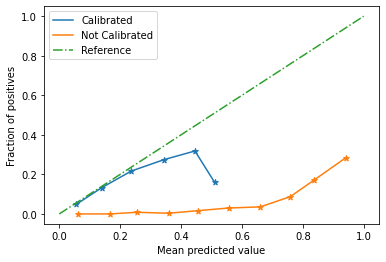

In [14]:
#Plotting

fraction_of_positives_o, mean_predicted_value_o = calibration_curve(y_true_test, y_pred_test[:,1], n_bins=10,normalize = True)
fraction_of_positives_platt, mean_predicted_value_platt = calibration_curve(y_true_test, y_calibrated_platt, n_bins=10)

plt.figure()
plt.plot(mean_predicted_value_platt, fraction_of_positives_platt, label = "Calibrated")
plt.scatter(mean_predicted_value_platt, fraction_of_positives_platt, marker = "*")

plt.plot(mean_predicted_value_o, fraction_of_positives_o, label = "Not Calibrated")
plt.scatter(mean_predicted_value_o, fraction_of_positives_o, marker = "*")

plt.plot(np.linspace(0,1),np.linspace(0,1),linestyle = "-.", label = "Reference")

plt.ylabel("Fraction of positives")
plt.xlabel("Mean predicted value")
plt.legend()
plt.show()

plt.figure()
plt.hist(y_calibrated_platt,range=(0, 1), bins=10)
plt.xlabel("Mean Predicted value")
plt.ylabel("Number of occurences")
plt.show()

### Isotonic calibration

In [15]:
import sklearn
from sklearn.calibration import CalibratedClassifierCV

class ModelSklearn(sklearn.base.BaseEstimator):
    def __init__(self,torch_model):
        self.torch_model = torch_model
        self.trainer = pl.Trainer(logger = False,gpus = 0)
        self.is_fitted_ = True
        self.classes_ = [0,1]
    def predict(self,X):
        with torch.no_grad():
            return torch.softmax(self.torch_model(torch.Tensor(X)),-1)[:,1]>0.5
    def predict_proba(self,X):
        with torch.no_grad():
            return torch.softmax(self.torch_model(torch.Tensor(X)),-1)
    def fit(self,X,y):
        return None

In [16]:
model_sk = ModelSklearn(model)

x_train, y_train = dataset.data_train.tensors
x_val, y_val = dataset.data_val.tensors
x_test, y_test = dataset.data_test.tensors

calibrated_clf = CalibratedClassifierCV(base_estimator=model_sk, cv="prefit", method = "isotonic")

_ = calibrated_clf.fit(x_val,y_val)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/edward/.cache/pypoetry/virtualenvs/ms-benchmark-K_Ybk8KV-py3.8/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1294: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  rank_zero_warn(


In [17]:
y_pred_test_prob = model_sk.predict_proba(x_test)[:,1]
y_calibrated_iso = calibrated_clf.predict_proba(x_test)[:,1]
roc_auc_score(y_test, y_calibrated_iso)

0.6974719912052231

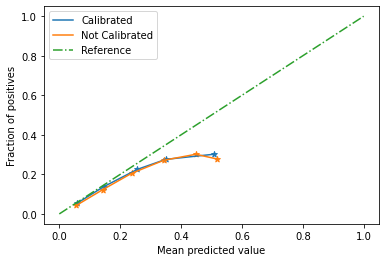

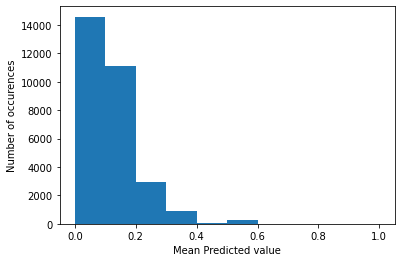

In [18]:
#Plotting

fraction_of_positives_o_prob, mean_predicted_value_o_prob = calibration_curve(y_test, y_pred_test_prob, n_bins=10)
fraction_of_positives_iso, mean_predicted_value_iso = calibration_curve(y_test, y_calibrated_iso, n_bins=10)

plt.figure()
plt.plot(mean_predicted_value_iso, fraction_of_positives_iso, label = "Calibrated")
plt.scatter(mean_predicted_value_iso, fraction_of_positives_iso,marker = "*")

plt.plot(mean_predicted_value_o_prob, fraction_of_positives_o_prob, label = "Not Calibrated")
plt.scatter(mean_predicted_value_o_prob, fraction_of_positives_o_prob, marker = "*")

plt.plot(np.linspace(0,1),np.linspace(0,1),linestyle = "-.", label = "Reference")

plt.ylabel("Fraction of positives")
plt.xlabel("Mean predicted value")
plt.legend()
plt.show()

plt.figure()
plt.hist(y_calibrated_iso,range=(0, 1), bins=10)
plt.xlabel("Mean Predicted value")
plt.ylabel("Number of occurences")
plt.show()

## Everything Together

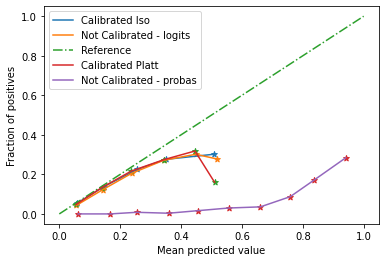

In [19]:
#Plotting

plt.figure()
plt.plot(mean_predicted_value_iso, fraction_of_positives_iso, label = "Calibrated Iso")
plt.scatter(mean_predicted_value_iso, fraction_of_positives_iso,marker = "*")

plt.plot(mean_predicted_value_o_prob, fraction_of_positives_o_prob, label = "Not Calibrated - logits")
plt.scatter(mean_predicted_value_o_prob, fraction_of_positives_o_prob, marker = "*")

plt.plot(np.linspace(0,1),np.linspace(0,1),linestyle = "-.", label = "Reference")


plt.plot(mean_predicted_value_platt, fraction_of_positives_platt, label = "Calibrated Platt")
plt.scatter(mean_predicted_value_platt, fraction_of_positives_platt, marker = "*")

plt.plot(mean_predicted_value_o, fraction_of_positives_o, label = "Not Calibrated - probas")
plt.scatter(mean_predicted_value_o, fraction_of_positives_o, marker = "*")

plt.ylabel("Fraction of positives")
plt.xlabel("Mean predicted value")
plt.legend()
plt.show()
